In [1]:
import csv
import numpy as np
from os import listdir
import os.path
from collections import OrderedDict
import igraph as ig
from six import iteritems, itervalues
#np.loadtxt()
data_path = '/home/armand/genetics/data/proves'
data_path = '/home/armand/genetics/data/vcfshorts/allfiles'
file_names = [os.path.join(data_path,f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path,f))]
#print (file_names)
file_names = file_names[:2]
field_names = ['#chrom1', 'start1', 'chrom2', 'start2', 'svclass']
all_files = []
all_links = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        tsv_in = csv.reader(f,  delimiter='\t')
        first_row = True
        b = []
        for a in tsv_in:
            if not first_row :
                b.append([a[0],int(a[1]),a[2],int(a[3]),a[4]])
            first_row = False
        all_files.append(b)
        all_links.extend(b)
        
print (all_links[:2])
print (all_files[:1])

[['1', 10152776, '2', 61762661, 'TRA'], ['1', 10455768, '1', 27983947, 't2tINV']]
[[['1', 10152776, '2', 61762661, 'TRA'], ['1', 10455768, '1', 27983947, 't2tINV'], ['1', 27203541, '1', 28035777, 'DUP'], ['1', 27215108, '19', 4001986, 'TRA'], ['1', 28035719, '2', 25686741, 'TRA'], ['1', 28795845, '2', 23574737, 'TRA'], ['1', 29460577, '2', 29035333, 'TRA'], ['1', 29500997, '2', 28793411, 'TRA'], ['1', 107128798, '1', 110102118, 'DUP'], ['1', 108038107, '1', 112786305, 't2tINV'], ['1', 108585735, '2', 96599516, 'TRA'], ['1', 109356638, '1', 113615264, 'DUP'], ['1', 109356789, '2', 96963704, 'TRA'], ['1', 110202415, '2', 96968785, 'TRA'], ['1', 110202775, '1', 114787741, 'DEL'], ['1', 113521095, '1', 114784968, 'DEL'], ['1', 113614959, '1', 114786023, 'DUP'], ['1', 113615264, '2', 96963703, 'TRA'], ['1', 114787742, '2', 96968849, 'TRA'], ['1', 177176863, '1', 177179579, 'DEL'], ['1', 179828093, '1', 179830715, 'DEL'], ['10', 63684059, '10', 63697601, 'DUP'], ['10', 77424570, '10', 775140

In [3]:
# Let's create a graph from it
# But first we need to know what are actually vertices and edges in our graph
# Gather all vertices in the data
def _pn(p):
    """ creates a string to encode a single point in genome"""
    return p[0] + '_' + str(p[1])

def _np(n):
    """ Get the point from the string"""
    p = n.split('_')
    p = [p[0],int(p[1])]
    return p

v_dict = {}
all_vertices_names = set()
for l in all_links:
    all_vertices_names.add(_pn(l[0:2]))
    all_vertices_names.add(_pn(l[2:4]))
all_vertices_names = list(all_vertices_names)
v_dict = {v:n for v,n in zip(all_vertices_names,range(len(all_vertices_names)))}

In [4]:
# Create the Graph with all real vertices and edges
g = ig.Graph()
for v in v_dict:
    p = _np(v)
    g.add_vertex(name=v, gene=p[0], locus=p[1])

for l in all_links:
    g.add_edge(v_dict[_pn(l[0:2])], v_dict[_pn(l[2:4])], abnormality=l[4], real_edge=True)

In [5]:
# Add extra edges when the vertices of a link are actually very close (i.e. may be actually same vertex)
def same_point(a,b,tol):
    """ Check if two points in genome are the same given a tolerance"""
    return (a[0] == b[0]) and (abs(a[1] - b[1]) <= tol)

def find_close_vertexs(g,v,tol):
    """
    g: Graph
    v: Vertex
    tol: tolerance: maximum allowed distance between locus
    """
    close_vertexs = []
    vs = g.vs.select(name_ne=v['name'])
    search_points = zip(vs, zip(vs['gene'], vs['locus']))
    target_point = (v['gene'], v['locus'])
    for v,p in search_points:
        if same_point(p, target_point, tol):
            close_vertexs.append(v)
    return close_vertexs
    
def duplicate_edge(g, e, v, is_source = True ):
    """
    Create a new vertex in g, from (to) v that point to same target (from same source) as e and have same attributes
    except for real_edge that now is False
    g: graph
    e: edge
    v: vertex
    is_source: if true v is the source for new edges, if false v is the target
    """
    if is_source:
        g.add_edge(v.index, e.target, abnormality=e['abnormality'], real_edge=False)
    else:
        g.add_edge(e.source, v.index, abnormality=e['abnormality'], real_edge=False)
    print ('edge added')
    return g

    
    
    
tol = 10000
for v in g.vs:
    print (v.index)
    close_vertexs = find_close_vertexs(g,v,tol)
    for cv in close_vertexs:
        print ('close vertex found')
        edges_out = g.es.select(_source=cv.index).select(lambda edge: edge['real_edge']==True)
        for e in edges_out:
            g = duplicate_edge(g, e, cv, is_source = True)
            
        edges_in = g.es.select(_target=cv.index).select(lambda edge: edge['real_edge']==True)
        for e in edges_in:
            g = duplicate_edge(g, e, cv, is_source = False)



0
1
close vertex found
edge added
2
3
4
5
close vertex found
edge added
6
7
close vertex found
edge added
8
9
close vertex found
edge added
10
close vertex found
edge added
11
12
13
close vertex found
edge added
14
close vertex found
edge added
15
close vertex found
edge added
close vertex found
edge added
close vertex found
edge added
16
close vertex found
edge added
17
18
19
20
close vertex found
edge added
21
close vertex found
edge added
22
23
close vertex found
edge added
24
close vertex found
edge added
25
26
close vertex found
edge added
27
close vertex found
edge added
28
29
close vertex found
edge added
30
31
close vertex found
edge added
32
close vertex found
edge added
33
close vertex found
edge added
34
close vertex found
edge added
35
close vertex found
edge added
36
close vertex found
edge added
37
38
39
40
41
close vertex found
edge added
42
close vertex found
edge added
43
44
45
46
close vertex found
edge added
47
close vertex found
edge added
48
49
close vertex found
e

559
close vertex found
edge added
560
close vertex found
edge added
561
562
close vertex found
edge added
563
564
565
close vertex found
edge added
566
567
568
close vertex found
edge added
569
close vertex found
edge added
570
571
close vertex found
edge added
572
close vertex found
edge added
573
close vertex found
edge added
574
close vertex found
edge added
close vertex found
edge added
close vertex found
edge added
close vertex found
edge added
close vertex found
edge added
575
576
close vertex found
edge added
577
close vertex found
edge added
578
close vertex found
edge added
579
580
close vertex found
edge added
581
close vertex found
edge added
582
close vertex found
edge added
edge added
583
584
close vertex found
edge added
585
586
587
close vertex found
edge added
close vertex found
edge added
close vertex found
edge added
588
589
590
close vertex found
edge added
591
close vertex found
edge added
592
593
594
close vertex found
edge added
595
596
close vertex found
edge add

In [43]:
print (len(g.es.select(real_edge_eq=True)))
print (len(g.es.select(real_edge_eq=False)))
print (len(g.es))

    

329
1728
2057


In [ ]:
print 

In [24]:
l = ['1', 10152776, '2', 61762661, 'TRA']
print ((v_dict[_pn(l[0:2])],v_dict[_pn(l[2:4])],('abnormality',l[4])))


(119, 416, ('abnormality', 'TRA'))


In [2]:
def same_point(a,b,tol):
    """ Check if two points in genome are the same given a tolerance"""
    return (a[0] == b[0]) and (abs(a[1] - b[1]) <= tol)


tol = 10000
all_points = []
for l in all_links:
    #l1 = l[0:2]
    #l2 = l[2:4]
    all_points.append(l[0:2])
    all_points.append(l[2:4])
    #print (l1, l2)
#print (all_points)
counter = OrderedDict()
for i, p1 in enumerate(all_points):
    #counter[_pn(p1)] = 0
    for p2 in all_points[i+1:]:
        if same_point(p1,p2,tol):
            if _pn(p1) in counter:
                counter[_pn(p1)] +=1
            else: 
                counter[_pn(p1)] =1
    
print (counter)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
print (counter[_pn(all_points[0])])

4


In [21]:
from six.moves import cPickle as pkl
file_counter = '/home/armand/genetics/data/counter10.pkl'
with open(file_counter, 'wb') as f:
    pkl.dump(counter,f)

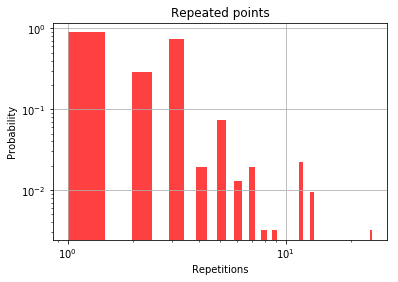

In [8]:
import matplotlib.pyplot as plt
from six import itervalues
# make a list of the ocurrences in counter
#x = list(itervalues(counter))
x = g.degree()
# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, log=True, facecolor='r', alpha=0.75)


plt.xlabel('Repetitions')
plt.ylabel('Probability')
plt.title('Repeated points')
plt.yscale('log')
plt.xscale('log')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [7]:
%matplotlib inline

In [45]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/home/armand/virtualenv/python3_tf/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
edges = [v_dict[_pn(l[0:2])],v_dict[_pn(l[2:4])],('translocation',l[4]) for l in all_links]
print (all_vertices_names[:2])
print (len(all_vertices_names))
print (len(v_dict))